In [15]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder

In [3]:
path = "../../data/raw/btsdelay/"
file_list = glob.glob(f"{path}*.parquet")

df = pd.concat([pd.read_parquet(i) for i in file_list])

In [4]:
pd.set_option('display.max_columns', 200)
df.head()

FlightDate            Airline Origin Dest  Cancelled  Diverted  CRSDepTime  \
0 2018-01-23  Endeavor Air Inc.    ABY  ATL      False     False        1202   
1 2018-01-24  Endeavor Air Inc.    ABY  ATL      False     False        1202   
2 2018-01-25  Endeavor Air Inc.    ABY  ATL      False     False        1202   
3 2018-01-26  Endeavor Air Inc.    ABY  ATL      False     False        1202   
4 2018-01-27  Endeavor Air Inc.    ABY  ATL      False     False        1400   

   DepTime  DepDelayMinutes  DepDelay  ArrTime  ArrDelayMinutes  AirTime  \
0   1157.0              0.0      -5.0   1256.0              0.0     38.0   
1   1157.0              0.0      -5.0   1258.0              0.0     36.0   
2   1153.0              0.0      -9.0   1302.0              0.0     40.0   
3   1150.0              0.0     -12.0   1253.0              0.0     35.0   
4   1355.0              0.0      -5.0   1459.0              0.0     36.0   

   CRSElapsedTime  ActualElapsedTime  Distance  Year  Quarter  Month  \
0            62.0               59.0     145.0  2018        1      1   
1            62.0               61.0     145.0  2018        1      1   
2            62.0               69.0     145.0  2018        1      1   
3            62.0               63.0     145.0  2018        1      1   
4            60.0               64.0     145.0  2018        1      1   

   DayofMonth  DayOfWeek Marketing_Airline_Network  \
0          23          2                        DL   
1          24          3                        DL   
2          25          4                        DL   
3          26          5                        DL   
4          27          6                        DL   

  Operated_or_Branded_Code_Share_Partners  DOT_ID_Marketing_Airline  \
0                            DL_CODESHARE                     19790   
1                            DL_CODESHARE                     19790   
2                            DL_CODESHARE                     19790   
3                            DL_CODESHARE                     19790   
4                            DL_CODESHARE                     19790   

  IATA_Code_Marketing_Airline  Flight_Number_Marketing_Airline  \
0                          DL                             3298   
1                          DL                             3298   
2                          DL                             3298   
3                          DL                             3298   
4                          DL                             3298   

  Operating_Airline  DOT_ID_Operating_Airline IATA_Code_Operating_Airline  \
0                9E                     20363                          9E   
1                9E                     20363                          9E   
2                9E                     20363                          9E   
3                9E                     20363                          9E   
4                9E                     20363                          9E   

  Tail_Number  Flight_Number_Operating_Airline  OriginAirportID  \
0      N8928A                             3298            10146   
1      N800AY                             3298            10146   
2      N8836A                             3298            10146   
3      N800AY                             3298            10146   
4      N8839E                             3298            10146   

   OriginAirportSeqID  OriginCityMarketID OriginCityName OriginState  \
0             1014602               30146     Albany, GA          GA   
1             1014602               30146     Albany, GA          GA   
2             1014602               30146     Albany, GA          GA   
3             1014602               30146     Albany, GA          GA   
4             1014602               30146     Albany, GA          GA   

   OriginStateFips OriginStateName  OriginWac  DestAirportID  \
0               13         Georgia         34          10397   
1               13         Georgia         34          

In [26]:
df['Season'] = np.where(df['Month'].isin([12,1,2]), 'Winter'
                        , np.where(df['Month'].isin([3,4,5]),'Spring'
                           , np.where(df['Month'].isin([6,7,8]),'Summer','Fall')))

Data is from Jan 2018 to July 2022

In [20]:
reg_data = df[['Origin', 'Month','Airline','DepDelayMinutes','Year']].copy()
reg_data = reg_data[(reg_data['Year']==2018)&(reg_data['DepDelayMinutes']<1000)]
reg_data['Delay_Ind'] = np.where(reg_data['DepDelayMinutes']> 5,1,0)
reg_data = reg_data.sample(n=1000000, random_state=1234)
feature_cols = ['Origin', 'Month','Airline']
#X = pd.get_dummies(reg_data[feature_cols])
X = reg_data[feature_cols]
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)
y = reg_data.Delay_Ind 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded.toarray(), y, test_size=0.25, random_state=1234)

Random Forest Classifier - Initial Model

In [31]:
rf = RandomForestClassifier(max_depth=10,n_estimators=10,random_state=1234)
# Train the model on training data
model = rf.fit(X_train, y_train);
#predict_proba

In [11]:
#model
predictions = model.predict_proba(X_test)
# #Run this to see predictions and features
# final_model = pd.concat([X_test.reset_index(drop=True),
#                pd.DataFrame(predictions).reset_index(drop=True)], axis=1)

# final_model = final_model.drop_duplicates()

In [12]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [10,25,30]
}
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 4 folds for each of 45 candidates, totalling 180 fits


C:\Users\JGres2\Anaconda3\envs\dviz3_7\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JGres2\Anaconda3\envs\dviz3_7\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JGres2\Anaconda3\envs\dviz3_7\lib\site-packages\sklearn\ensemble\_forest.py", line 328, in fit
    X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
  File "C:\Users\JGres2\Anaconda3\envs\dviz3_7\lib\site-packages\sklearn\base.py", line 581, in _validate_dat

0.7324573333333333

In [13]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=10,
                       random_state=1234)

Updated Model with Hyperparameter Tuning

In [33]:
rf_final = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=10)
model_final = rf_final.fit(X_train, y_train);
predictions_final = model_final.predict_proba(X_test)

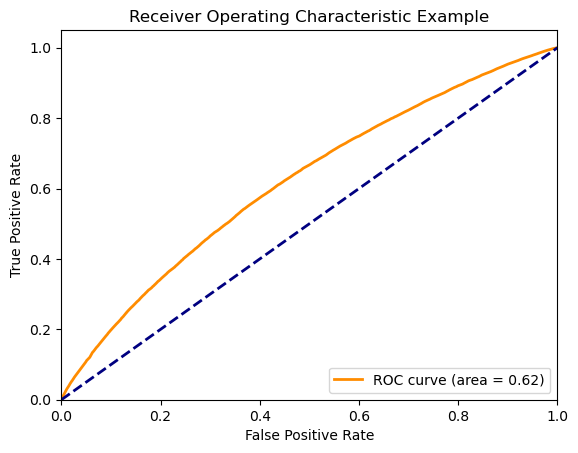

In [34]:
from sklearn.metrics import roc_curve, auc
# Compute the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, predictions_final[:,1])

# Compute the area under the curve (AUC) score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

In [35]:
pickle.dump(rf_final, open('rf_model.pkl','wb'))

In [59]:
model_open = pickle.load(open('rf_model.pkl','rb'))

# # Separate features and target
# X_new = new_data[['Origin', 'Month', 'Airline']]
# y_new = new_data['Delay_Ind']

# # Encode the new data using the same OneHotEncoder object
# X_new_encoded = encoder.transform(X_new)

# # Make predictions on the new data
# predictions = model_open.predict_proba(X_new_encoded)

# # Reverse the one-hot encoding to get the predicted class labels
# predicted_labels = np.argmax(predictions, axis=1)